In [2]:

# Load the dataset
df = pd.read_csv('Dataset\sgemm_product.csv')
df['Runtime'] = df[['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)']].mean(axis=1)


In [2]:

# Dataset structure and summary statistics
print("Dataset Structure:", df.shape)
print("\nSummary Statistics:")
print(df.describe())


Dataset Structure: (241600, 19)

Summary Statistics:
                 MWG            NWG            KWG          MDIMC  \
count  241600.000000  241600.000000  241600.000000  241600.000000   
mean       80.415364      80.415364      25.513113      13.935894   
std        42.469220      42.469220       7.855619       7.873662   
min        16.000000      16.000000      16.000000       8.000000   
25%        32.000000      32.000000      16.000000       8.000000   
50%        64.000000      64.000000      32.000000       8.000000   
75%       128.000000     128.000000      32.000000      16.000000   
max       128.000000     128.000000      32.000000      32.000000   

               NDIMC          MDIMA          NDIMB            KWI  \
count  241600.000000  241600.000000  241600.000000  241600.000000   
mean       13.935894      17.371126      17.371126       5.000000   
std         7.873662       9.389418       9.389418       3.000006   
min         8.000000       8.000000       8.00000

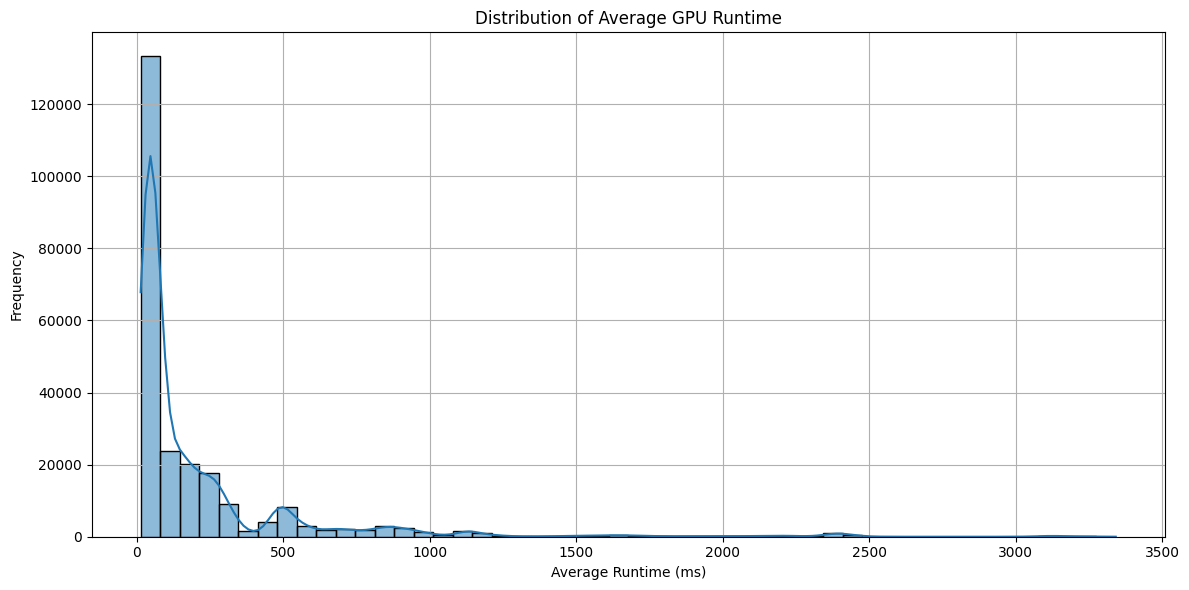

In [3]:

# Distribution plot for the average runtime
plt.figure(figsize=(12, 6))
sns.histplot(df['Runtime'], bins=50, kde=True)
plt.title('Distribution of Average GPU Runtime')
plt.xlabel('Average Runtime (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


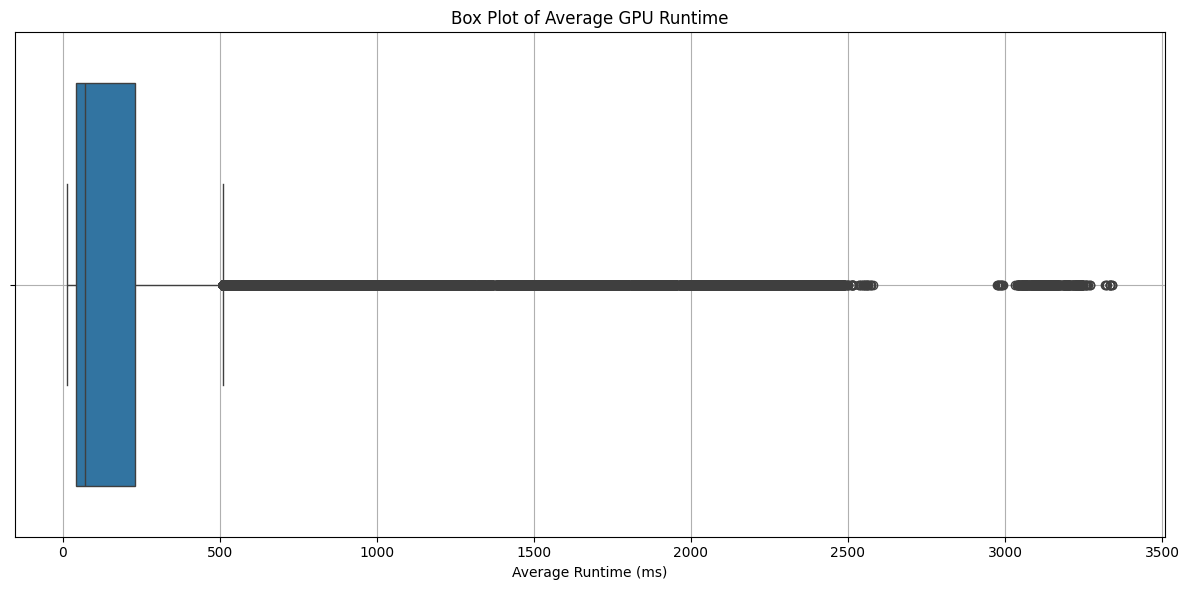

In [4]:

# Box plot for the average runtime
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Runtime'])
plt.title('Box Plot of Average GPU Runtime')
plt.xlabel('Average Runtime (ms)')
plt.grid(True)
plt.tight_layout()
plt.show()


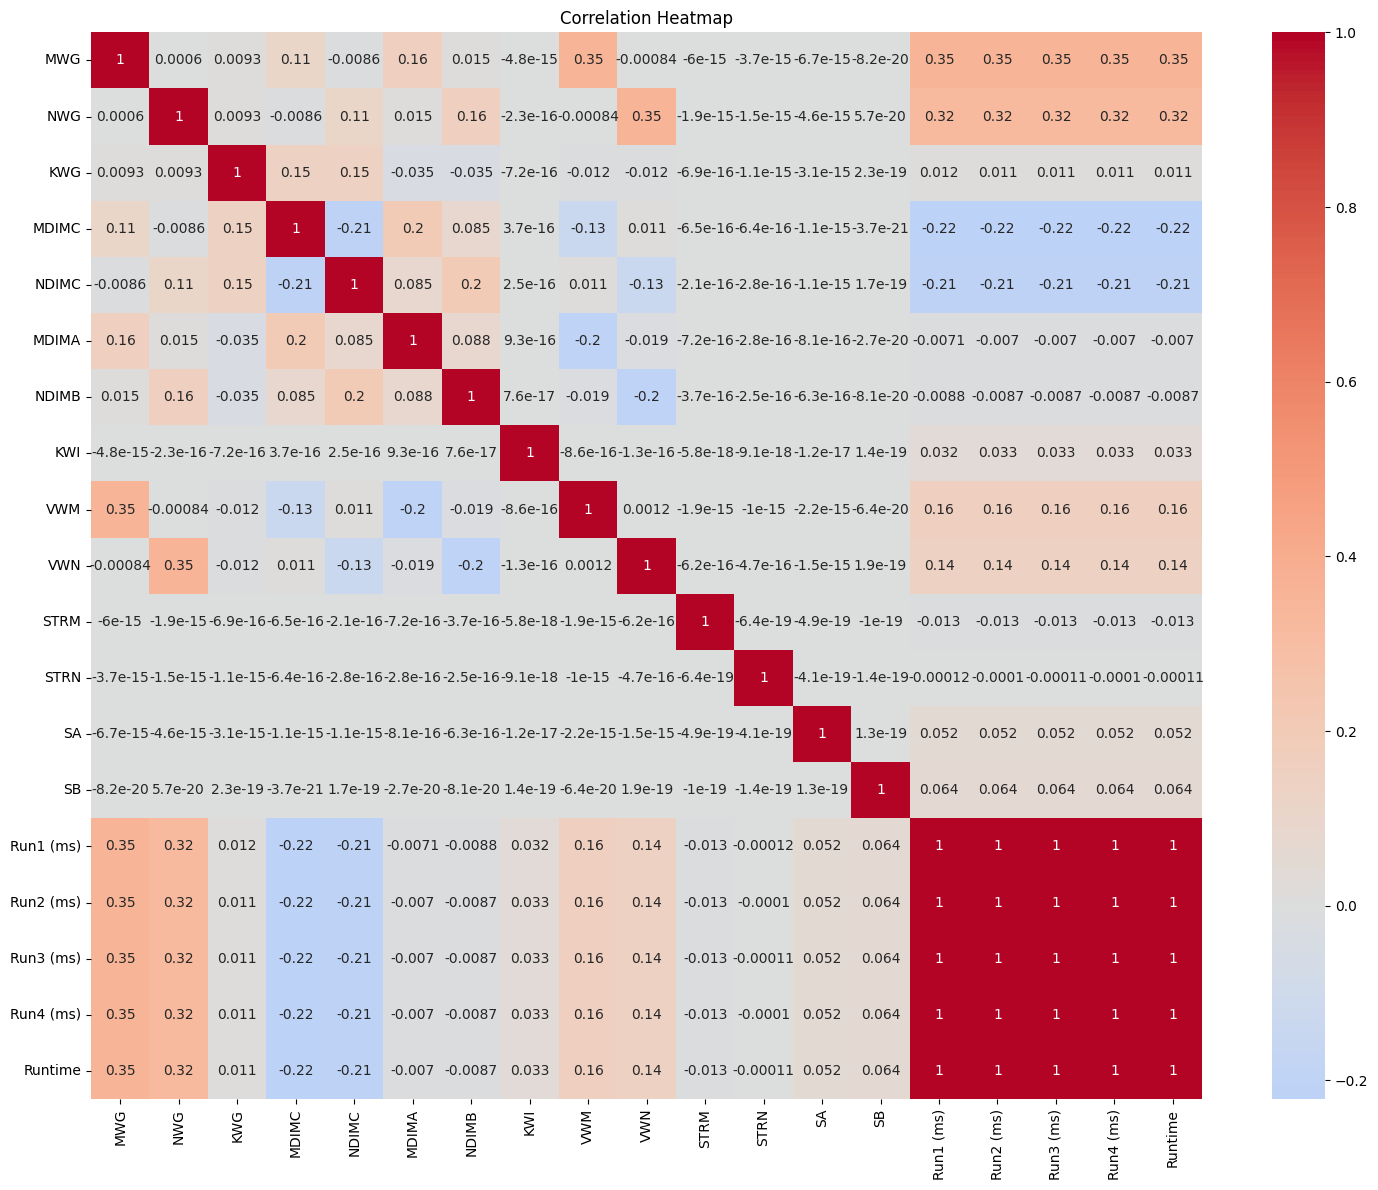

In [5]:

# Correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


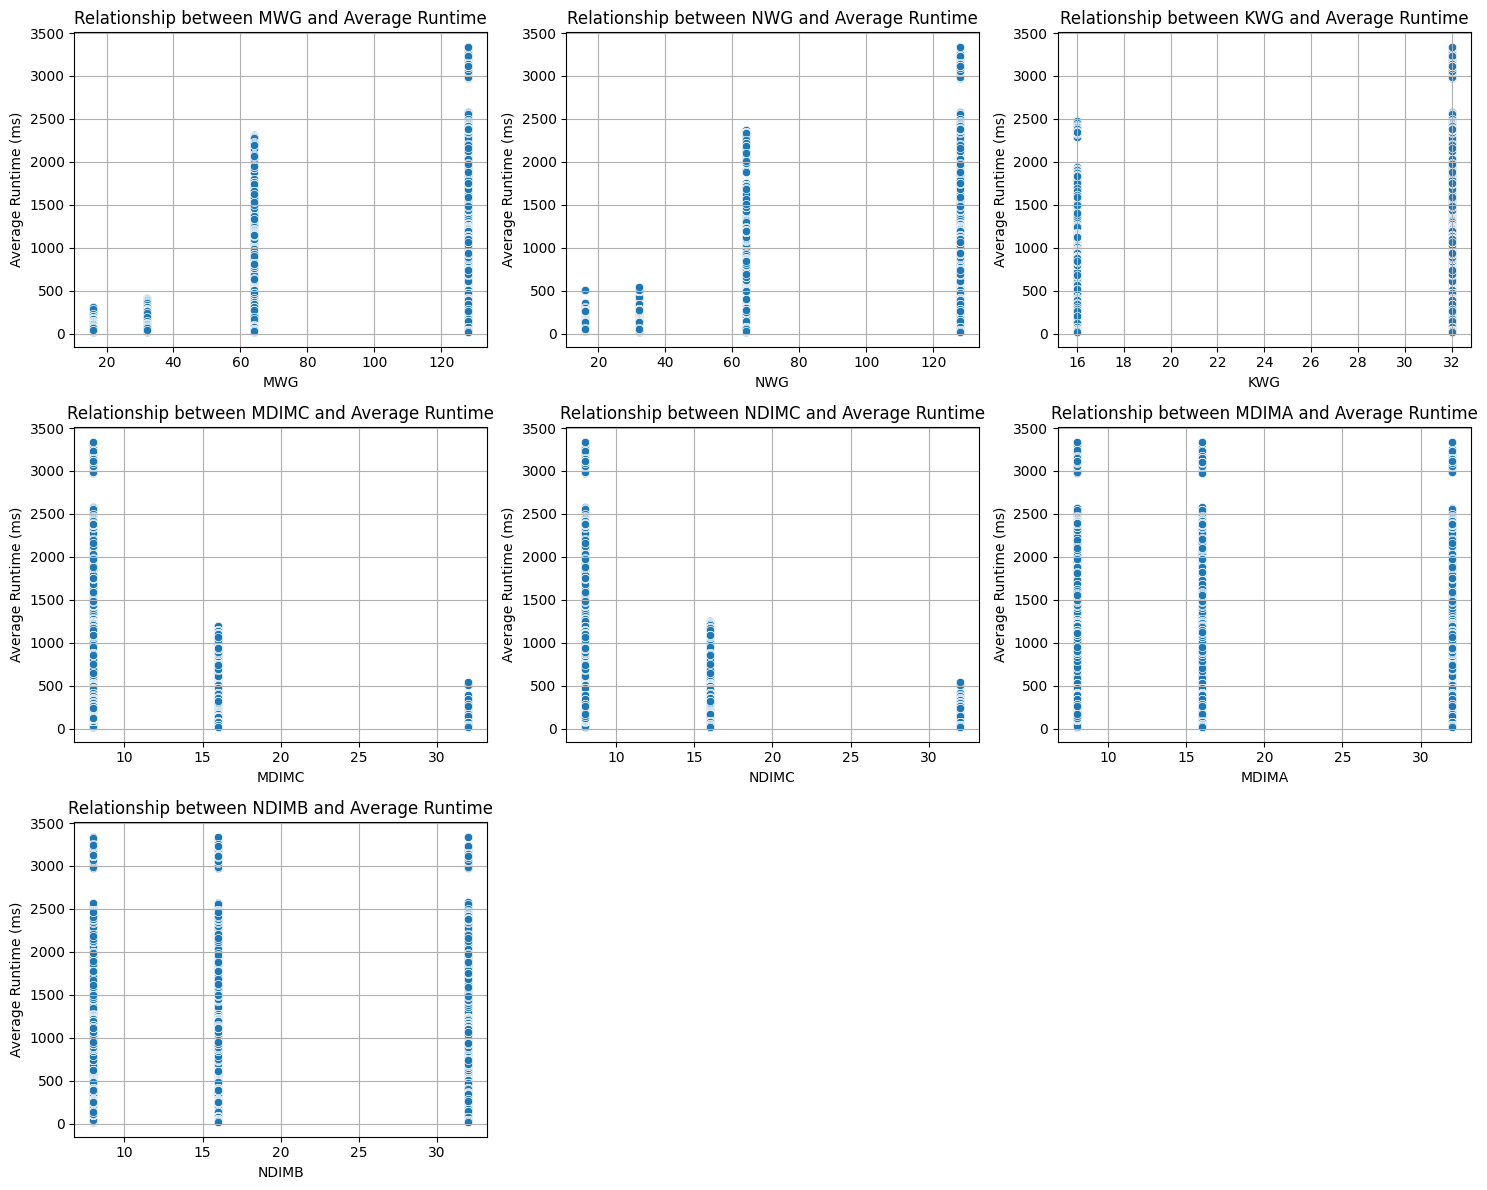

In [6]:

continuous_features = ['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB']
plt.figure(figsize=(15, 12))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df[feature], y=df['Runtime'])
    plt.title(f'Relationship between {feature} and Average Runtime')
    plt.ylabel('Average Runtime (ms)')
    plt.grid(True)
plt.tight_layout()
plt.show()


These scatter plots provide insights into how different GPU configurations might influence the runtime. Some features, like MWG and NWG, seem to have a more direct impact on the runtime compared to others.

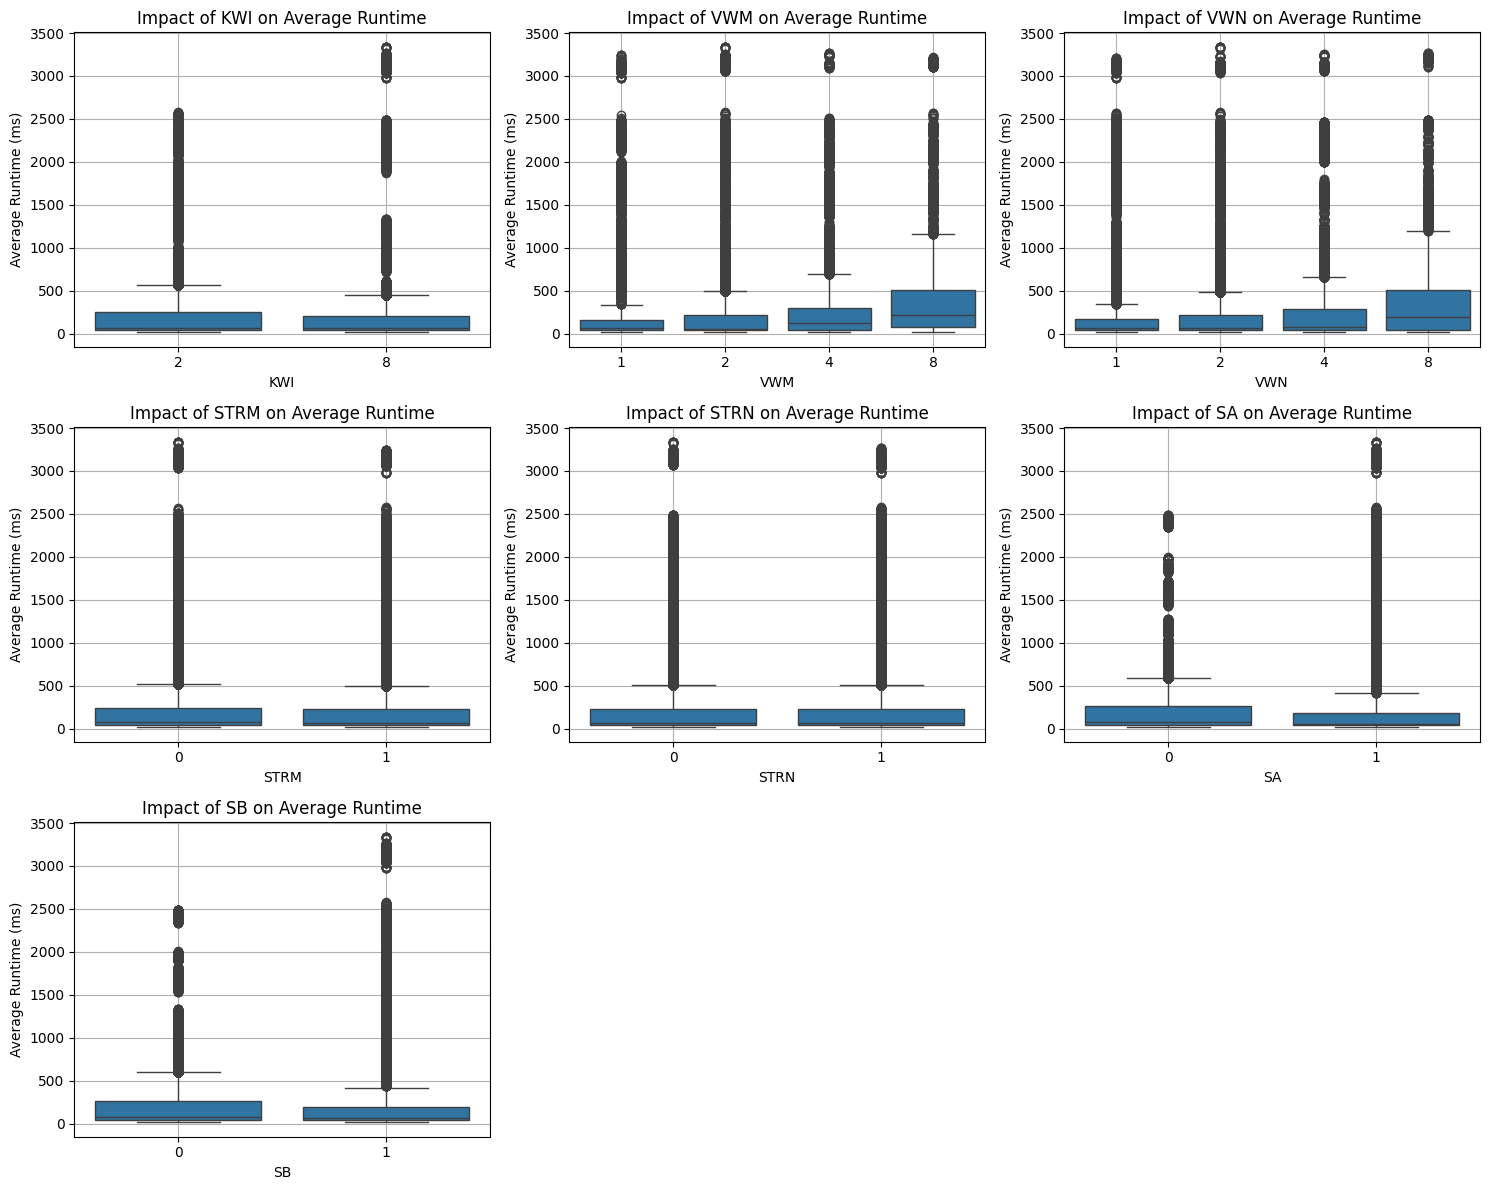

In [7]:

categorical_features = ['KWI', 'VWM', 'VWN', 'STRM', 'STRN', 'SA', 'SB']
plt.figure(figsize=(15, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[feature], y=df['Runtime'])
    plt.title(f'Impact of {feature} on Average Runtime')
    plt.ylabel('Average Runtime (ms)')
    plt.grid(True)
plt.tight_layout()
plt.show()


These Box plots provide insights into how different GPU configurations or settings impact the runtime. The spread of the data and the median values can give an understanding of the typical runtime for each category.

c:\Users\shreyas\miniconda3\envs\torch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


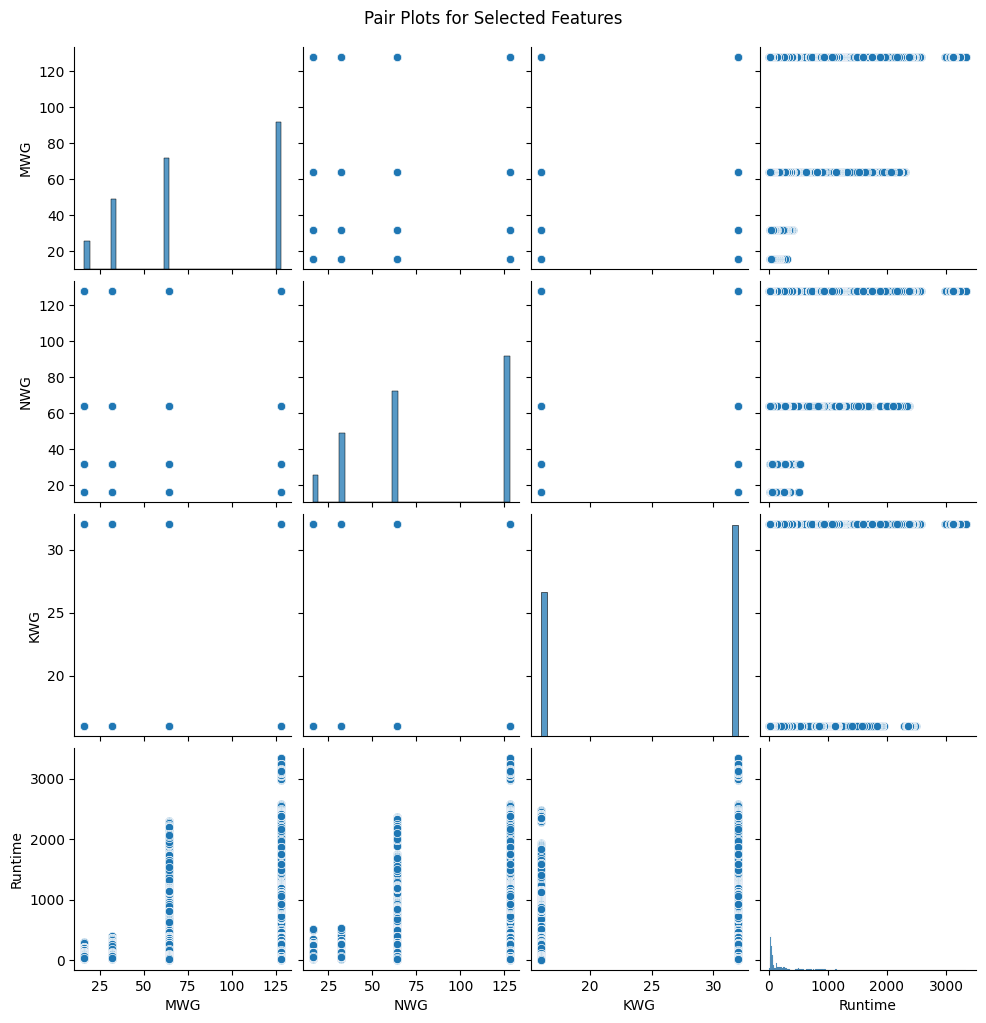

In [8]:

# Subset of features for pair plot
subset_features = ['MWG', 'NWG', 'KWG', 'Runtime']
sns.pairplot(df[subset_features])
plt.suptitle('Pair Plots for Selected Features', y=1.02)
plt.show()


Pair plots provide a comprehensive view of both individual feature distributions and pairwise relationships, which can be useful for understanding interactions between features and their collective impact on the target variable. 


### Preprocessing Steps

Based on the insights from our initial EDA , we'll apply the following preprocessing steps:

1. **Outlier Removal**: Remove outliers from the `Runtime` column based on the Interquartile Range (IQR) method.
2. **Log Transformation**: Address the skewness in the `Runtime` distribution by log-transforming it.
3. **Feature Scaling**: Scale the feature columns using `MinMaxScaler` to bring all features to a similar scale.

Let's apply these preprocessing steps and visualize the differences.


In [3]:
df.drop(['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)'], axis=1, inplace=True)
# Outlier Removal using IQR for 'Runtime'
Q1 = df['Runtime'].quantile(0.25)
Q3 = df['Runtime'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Runtime'] < (Q1 - 1.5 * IQR)) | (df['Runtime'] > (Q3 + 1.5 * IQR)))]

# Log-transform the 'Runtime' column
df['target'] = np.log1p(df['Runtime'])

# Scaling the features using MinMaxScaler
features = df.drop(['Runtime', 'target'], axis=1)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)
df_scaled['target'] = df['target'].values


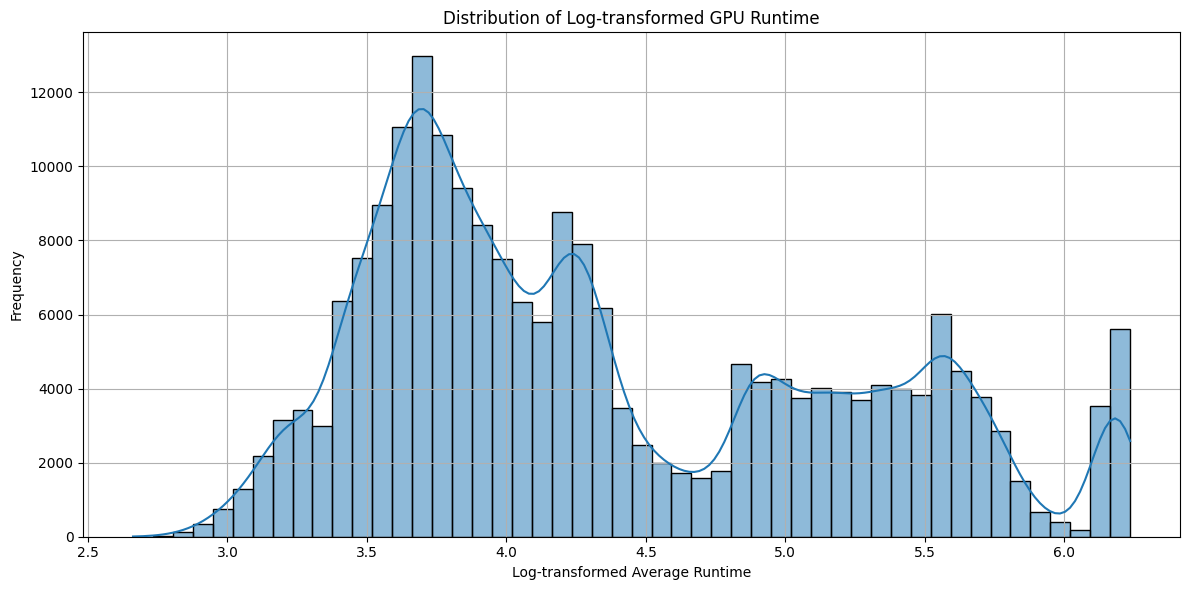

In [4]:

# Distribution plot for the log-transformed target
plt.figure(figsize=(12, 6))
sns.histplot(df['target'], bins=50, kde=True)
plt.title('Distribution of Log-transformed GPU Runtime')
plt.xlabel('Log-transformed Average Runtime')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()



**Distribution of Log-transformed GPU Runtime**:
- The distribution becomes more symmetric post log-transformation.
- The log-transformed runtime values mainly lie between 4 and 6, indicating effective transformation.


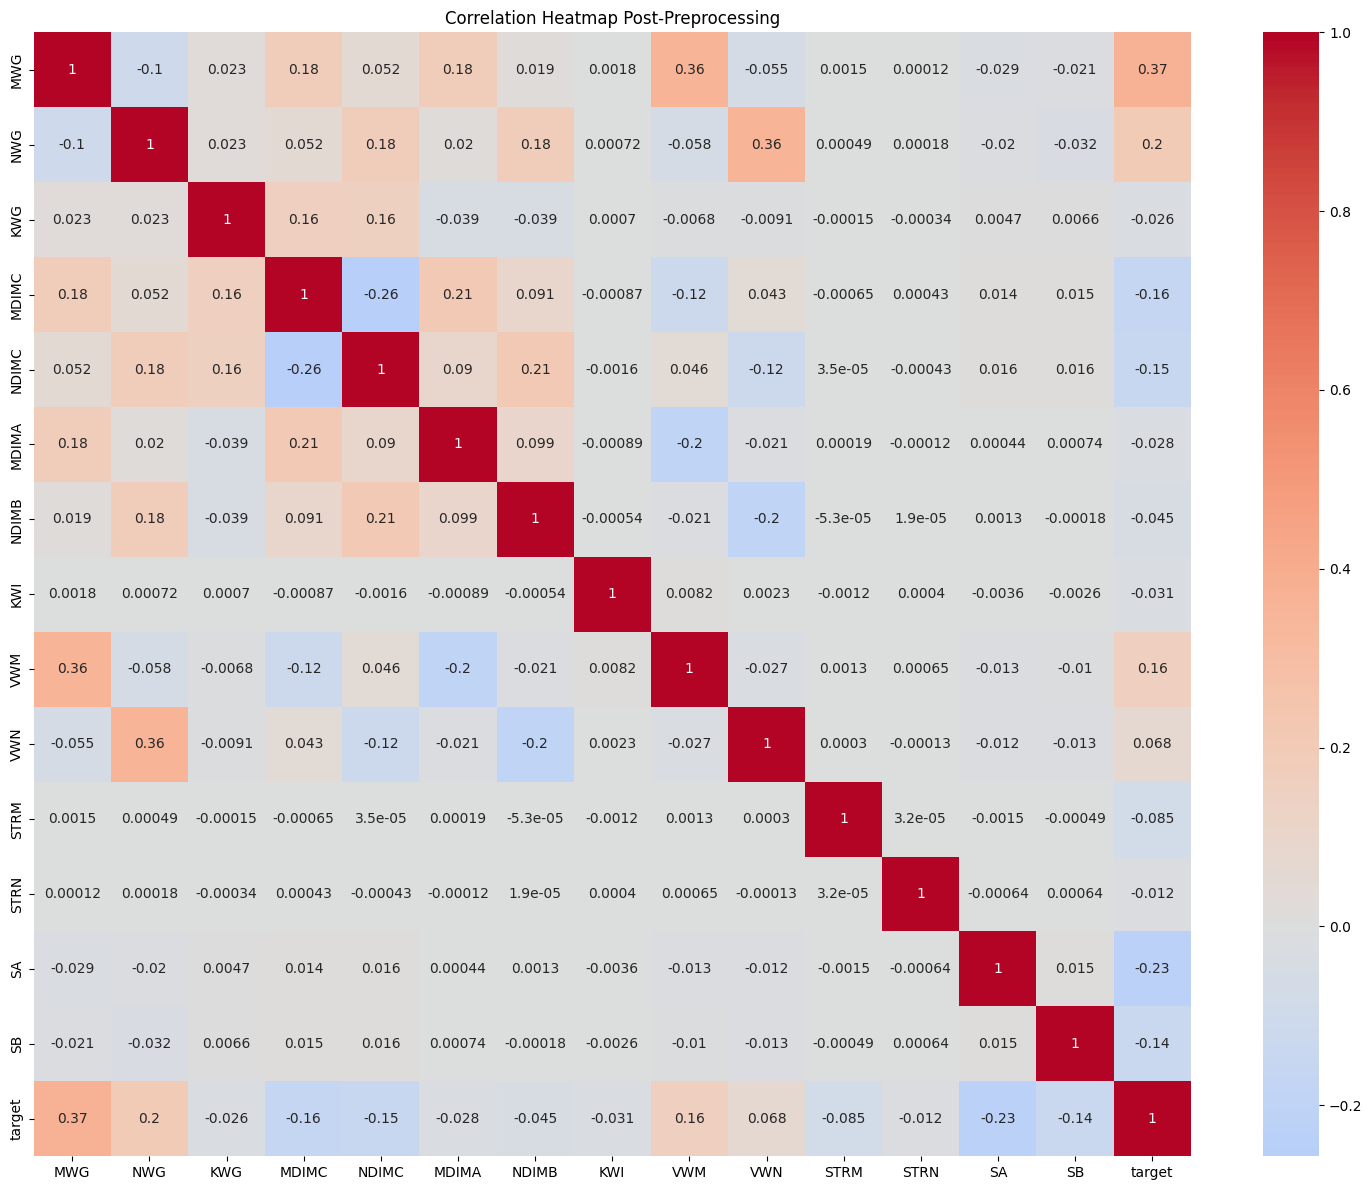

In [5]:

# Correlation heatmap post-preprocessing
plt.figure(figsize=(15, 12))
sns.heatmap(df_scaled.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap Post-Preprocessing')
plt.tight_layout()
plt.show()



**Correlation Heatmap Post-Preprocessing**:
- The heatmap visualizes the correlation coefficients after preprocessing.
- Features like `MWG`, `NWG`, `MDIMC`, and `NDIMC` display relatively high positive correlations with the log-transformed target.


**Split the dataset**

In [6]:

from sklearn.model_selection import train_test_split


# Splitting the preprocessed data into training and test sets
X = df_scaled.drop('target', axis=1)
y = df_scaled['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the training and test sets in the "dataset" folder
X_train.to_csv('Dataset/X_train.csv', index=False)
X_test.to_csv('Dataset/X_test.csv', index=False)
y_train.to_csv('Dataset/y_train.csv', index=False)
y_test.to_csv('Dataset/y_test.csv', index=False)
